In [108]:
# Ensure that we re-load changes automagically
%load_ext autoreload
%autoreload 2

import torch
from transformers import *

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt

from transformer_utils import TransformerRSM

STIMULUS = "black" # 21st_year, pieman, slumlordreach, black
MODEL = 'bert-base-uncased' # bert-base-uncased, gpt2

foo = TransformerRSM(STIMULUS, model_name=MODEL, verbose=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Looking for TR-aligned tokens in data/stimuli/black/tr_tokens.csv
Loaded 534 TRs.


# Layerwise Activations

In [109]:
foo.process_stimulus_activations()

Processed 534 TRs for activations.


In [3]:
foo.model_name

'bert-base-uncased'

In [4]:
for layer in range(0, 13):

    layer_activations = foo.layer_activations_from_tensor(foo.stimulus_df["activations"], layer)
    layer_mean_embeddings = np.array([l.mean(0).numpy() for l in layer_activations])
    np.save("{}_{}_layer_{}_activations.npy".format(STIMULUS, MODEL, layer), layer_mean_embeddings)
    
    print(layer_mean_embeddings.shape)
    
#     df["layer_{}".format(layer)] = layer_mean_embeddings

(534, 768)
(534, 768)
(534, 768)
(534, 768)
(534, 768)
(534, 768)
(534, 768)
(534, 768)
(534, 768)
(534, 768)
(534, 768)
(534, 768)
(534, 768)


# Layerwise Attentions
Important question: how many prior tokens should we take for attention metric context?

count    534.000000
mean       3.280899
std        1.914625
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max       11.000000
Name: n_transformer_tokens_in_tr, dtype: float64


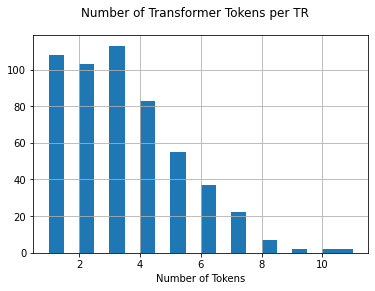

In [5]:
print(foo.stimulus_df.n_transformer_tokens_in_tr.describe())
foo.stimulus_df.n_transformer_tokens_in_tr.hist(bins=20);
plt.suptitle("Number of Transformer Tokens per TR")
plt.xlabel("Number of Tokens");

In [84]:
# Median number of tokens per TR is 5; 75th percentile is 7.
# Assuming we're using about 30 seconds of prior context, that's 20 TRs, so we should take 100-140 context tokens. (yikes-- we've been doing 20!)

N_ATTENTION_TOKENS = 10 # 20, 128

In [85]:
foo.verbose = False
foo.process_stimulus_attentions(num_window_tokens=N_ATTENTION_TOKENS)

Processing TR 0
Processing TR 100
Processing TR 200
Processing TR 300
Processing TR 400
Processing TR 500


In [86]:
print("Successfully produced attention maps for {} of {} TRs.".format( 
    len(foo.stimulus_df[~foo.stimulus_df.attentions.isnull()]), len(foo.stimulus_df)))

Successfully produced attention maps for 531 of 534 TRs.


In [87]:
has_attentions = foo.stimulus_df[foo.stimulus_df.attentions.isnull()]
failed_attentions = foo.stimulus_df[~foo.stimulus_df.attentions.isnull()]

# Masking Attention

All of the below analyses can / should be run with various parameter settings.

They run much faster than the original activation / attention code and do various masking and summarization procedures on the raw data.

In [102]:
BACKWARD_ATTENTION = False

if BACKWARD_ATTENTION:
    ATTENTION_DIRECTION = "bck"
else:
    ATTENTION_DIRECTION = "fwd"

In [103]:
foo.mask_non_tr_attentions(include_forwards=not BACKWARD_ATTENTION, 
                           include_backwards=BACKWARD_ATTENTION)

In [104]:
foo.compute_attention_head_magnitudes(p=1)
foo.compute_attention_head_magnitudes(p='inf')

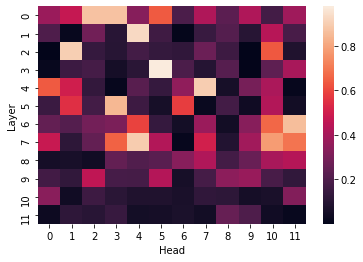

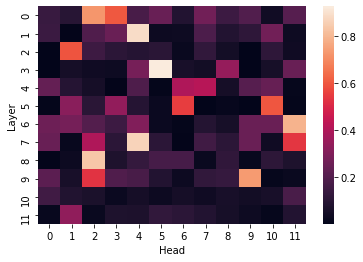

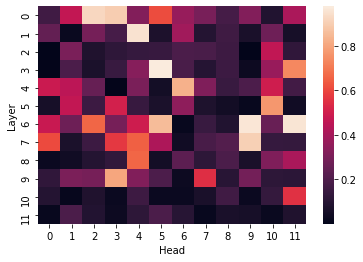

In [105]:
for x in [90, 150, 200]:
    plt.figure()
    sns.heatmap(foo.stimulus_df.attention_heads_Linf.iloc[x])
    plt.xlabel("Head")
    plt.ylabel("Layer")

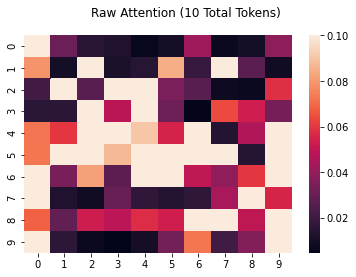

In [106]:
sns.heatmap(foo.stimulus_df.attentions.iloc[50][0][11], vmax=.1)
plt.suptitle("Raw Attention ({} Total Tokens)".format(N_ATTENTION_TOKENS));

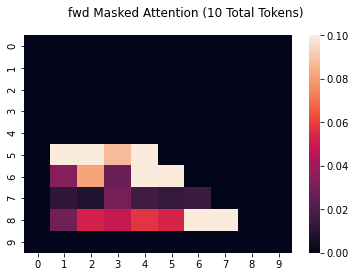

In [107]:
sns.heatmap(foo.stimulus_df.masked_attentions.iloc[50][0][11], vmax=.1)
plt.suptitle("{} Masked Attention ({} Total Tokens)".format(ATTENTION_DIRECTION, N_ATTENTION_TOKENS));

In [108]:
foo.compute_attention_head_distances()

Processing TR 0.
Processing TR 100.
Processing TR 200.
Processing TR 300.
Processing TR 400.
Processing TR 500.


In [109]:
foo.stimulus_df.attention_distances

0                                                   None
1                                                   None
2                                                   None
3      [[4.741390408948064, 8.862544691190124, 4.1391...
4      [[2.84527999535203, 4.077132673934102, 1.33706...
                             ...                        
529    [[2.716287925839424, 3.1112320199608803, 1.089...
530    [[2.716287925839424, 3.1112320199608803, 1.089...
531    [[2.716287925839424, 3.1112320199608803, 1.089...
532    [[2.716287925839424, 3.1112320199608803, 1.089...
533    [[2.3917427733540535, 2.679509771987796, 1.030...
Name: attention_distances, Length: 534, dtype: object

<AxesSubplot:>

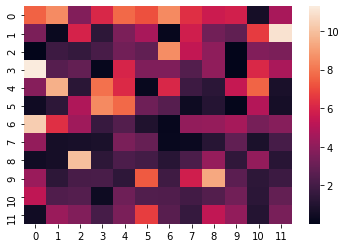

In [110]:
sns.heatmap(foo.stimulus_df.attention_distances.iloc[400])

# Outputs for Sreejan

In [111]:
import itertools

def flatten(lists):
    if lists is None:
        return None
    else:
        return list(itertools.chain.from_iterable(lists))

### Syntactic Complexity

In [112]:
for p in [1, 'inf']:  # can also do p=2, but not using that currently.

    COMPLEXITY_OUTPUT_FILE = "{}_{}_syntactic_complexity_L-{}_T-{}_D-{}.npy".format(STIMULUS, MODEL, p, N_ATTENTION_TOKENS, ATTENTION_DIRECTION)
    print("Outputting metrics to {}".format(COMPLEXITY_OUTPUT_FILE))

    attention_vectors = foo.stimulus_df["attention_heads_L{}".format(p)].apply(lambda x: flatten(x))

    attention_np_arrays = np.array(attention_vectors)
    print(attention_np_arrays.shape)
    np.save(COMPLEXITY_OUTPUT_FILE, attention_np_arrays)

# baz = np.load(OUTPUT_FILE, allow_pickle=True)
# baz[:10]

Outputting metrics to black_bert-base-uncased_syntactic_complexity_L-1_T-10_D-fwd.npy
(534,)
Outputting metrics to black_bert-base-uncased_syntactic_complexity_L-inf_T-10_D-fwd.npy
(534,)


### Syntactic Distance

In [99]:
DISTANCE_OUTPUT_FILE = "{}_{}_syntactic_distance_T-{}_D-{}.npy".format(STIMULUS, MODEL, N_ATTENTION_TOKENS, ATTENTION_DIRECTION)

attention_distance_vectors = foo.stimulus_df["attention_distances".format(p)].apply(lambda x: flatten(x))
attention_np_arrays = np.array(attention_distance_vectors)
print(attention_np_arrays.shape)

np.save(DISTANCE_OUTPUT_FILE, attention_np_arrays)

# baz = np.load(DISTANCE_OUTPUT_FILE, allow_pickle=True)
# baz

(534,)


# Semantic Composition

(F.K.A "Attention Effects")

### End-to-end
How far do tokens "move in space" from the initial embeddings to final outputs?

`activation_end_to_end_l2_distances[n_token]` gives the start-to-finish displacement of the contextualization process. Longer distances indicates the token's meaning was changed more during contextualization.

In [100]:
foo.end_to_end_token_movement()

def normalize_col(col):
    
    de_meaned = col - col.mean()
    return de_meaned / de_meaned.std()

foo.stimulus_df["activation_end_to_end_mean_l2"] = foo.stimulus_df["activation_end_to_end_l2_distances"].apply(lambda x: np.mean(x))
foo.stimulus_df["activation_end_to_end_max_l2"] = foo.stimulus_df["activation_end_to_end_l2_distances"].apply(lambda x: np.max(x))

foo.stimulus_df.activation_end_to_end_mean_l2 = normalize_col(foo.stimulus_df.activation_end_to_end_mean_l2)
foo.stimulus_df.activation_end_to_end_max_l2 = normalize_col(foo.stimulus_df.activation_end_to_end_max_l2)

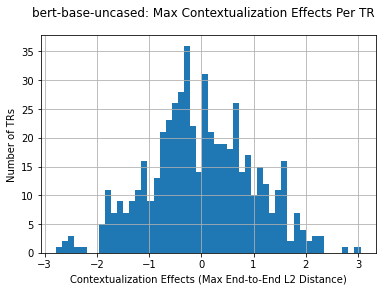

In [101]:
foo.stimulus_df.activation_end_to_end_max_l2.hist(bins=50)
plt.suptitle("{}: Max Contextualization Effects Per TR".format(foo.model_name));
plt.xlabel("Contextualization Effects (Max End-to-End L2 Distance)")
plt.ylabel("Number of TRs");

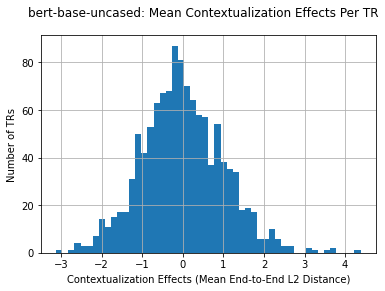

In [81]:
foo.stimulus_df.activation_end_to_end_mean_l2.hist(bins=50)
plt.suptitle("{}: Mean Contextualization Effects Per TR".format(foo.model_name));
plt.xlabel("Contextualization Effects (Mean End-to-End L2 Distance)")
plt.ylabel("Number of TRs");

# Semantic Composition Output
### Outputting Layerwise Token Movement 
`activation_layerwise_l2_distances[n_layer][n_token]` gives the L2 distance that each token moved, each layer.

We can look at the mean or max distance for each layer + token.

### Run the embeddings with a defined number of context windows

In [111]:
N_CONTEXT_TRS = 0 # 5, 20

foo.verbose = False
foo.process_stimulus_activations(num_context_trs=N_CONTEXT_TRS)

Processed 534 TRs for activations.


In [112]:
foo.layerwise_token_movement()
foo.end_to_end_token_movement()

In [113]:
def normalize_col(col):
    
    de_meaned = col - col.mean()
    return de_meaned / de_meaned.std()

end_to_end_mean_l2 = foo.stimulus_df["activation_end_to_end_l2_distances"].apply(lambda x: np.mean(x))
foo.stimulus_df["activation_end_to_end_mean_l2_normed"] = normalize_col(end_to_end_mean_l2)

end_to_end_max_l2 = foo.stimulus_df["activation_end_to_end_l2_distances"].apply(lambda x: np.max(x))
foo.stimulus_df["activation_end_to_end_max_l2_normed"] = normalize_col(end_to_end_max_l2)

In [114]:
layerwise_mean_l2 = foo.stimulus_df["activation_layerwise_l2_distances"].apply(lambda x: [np.mean(layer) for layer in x])
foo.stimulus_df["activation_layerwise_mean_l2"] = layerwise_mean_l2

layerwise_max_l2 = foo.stimulus_df["activation_layerwise_l2_distances"].apply(lambda x: [np.max(layer) for layer in x])
foo.stimulus_df["activation_layerwise_max_l2"] = layerwise_max_l2

len(foo.stimulus_df["activation_layerwise_l2_distances"][0][0])

2

In [115]:
for metric in ["max", "mean"]:

    df = pd.DataFrame.from_records(foo.stimulus_df["activation_layerwise_{}_l2".format(metric)])

    normalized = (df-df.mean())/df.std()
    normalized.apply([np.mean, np.std])
    foo.stimulus_df["activation_layerwise_{}_l2_normed".format(metric)] = [list(r) for r in normalized.to_records(index=False)]

In [116]:
full_lists = []
for i, tr in foo.stimulus_df.iterrows():
    
    max_composition = tr["activation_layerwise_max_l2_normed"] + [tr['activation_end_to_end_max_l2_normed']]
    mean_composition = tr["activation_layerwise_mean_l2_normed"] + [tr['activation_end_to_end_mean_l2_normed']]
    full_lists.append(max_composition + mean_composition)
    
foo.stimulus_df["full_semantic_composition"] = full_lists
attention_effects_array = np.array(foo.stimulus_df[['full_semantic_composition']])

np.save("{}_{}_semantic_composition_{}-TRs.npy".format(STIMULUS, MODEL, N_CONTEXT_TRS), attention_effects_array)

### Sanity-check dimensions
We should have N_TRs x 2 x N_LAYER+1:

In [153]:
print(foo.stimulus_df["full_semantic_composition"].shape)
print(len(foo.stimulus_df["full_semantic_composition"][0]))

(534,)
26


## Final Semantic Composition .npy write

In [122]:
foo.semantic_composition_from_activations()

In [127]:
foo.stimulus_df[foo.stimulus_df.semantic_composition == foo.stimulus_df.full_semantic_composition]

,tr,start_ts,end_ts,tr.1,phoneme_vector,n_phonemes,tokens,n_tokens,tr_shift,prev_tr,...,activation_layerwise_l2_distances,activation_end_to_end_l2_distances,activation_end_to_end_mean_l2_normed,activation_end_to_end_max_l2_normed,activation_layerwise_mean_l2,activation_layerwise_max_l2,activation_layerwise_max_l2_normed,activation_layerwise_mean_l2_normed,full_semantic_composition,semantic_composition
0,0,0.24,1.26,0,"[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, ...",3.0,So I,2.0,NaN,NaN,...,"[[9.863197326660156, 9.544010162353516], [8.03...","[18.028287887573242, 18.45259666442871]",-0.477248,-1.056626,"[9.703603744506836, 7.883480548858643, 8.26190...","[9.863197326660156, 8.036924362182617, 8.30698...","[-0.9379636390856837, -1.4579013402620518, -0....","[-0.2241099365697535, -1.1193412429172198, -0....","[-0.9379636390856837, -1.4579013402620518, -0....","[-0.9379636390856837, -1.4579013402620518, -0...."
1,1,1.96,2.45,1,"[0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...",4.0,was a,2.0,1.0,0.0,...,"[[8.367582321166992, 8.623529434204102], [6.85...","[16.258790969848633, 14.89378547668457]",-2.835992,-2.649477,"[8.495555877685547, 7.424961566925049, 6.88496...","[8.623529434204102, 7.9969587326049805, 7.0862...","[-2.2975460133703485, -1.495448194034524, -1.9...","[-2.2909398392894906, -1.821850066783626, -2.3...","[-2.2975460133703485, -1.495448194034524, -1.9...","[-2.2975460133703485, -1.495448194034524, -1.9..."
2,2,2.46,4.20,2,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...",12.0,junior in college,3.0,1.0,1.0,...,"[[13.671257019042969, 9.505199432373047, 10.73...","[21.233692169189453, 19.95167350769043, 20.191...",1.487036,0.962638,"[11.303675969441732, 8.365735212961832, 8.5389...","[13.671257019042969, 9.227483749389648, 9.2398...","[3.2384539881628887, -0.3393962724995263, -0.0...","[2.513428212236045, -0.3804663648161289, 0.182...","[3.2384539881628887, -0.3393962724995263, -0.0...","[3.2384539881628887, -0.3393962724995263, -0.0..."
3,3,4.79,5.59,3,"[0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, ...",9.0,when I got my,4.0,1.0,2.0,...,"[[9.572195053100586, 9.739704132080078, 10.515...","[16.95180892944336, 17.84522247314453, 19.4367...",-0.796458,-0.342034,"[10.075659990310669, 8.394703149795532, 7.7035...","[10.515669822692871, 9.30056095123291, 8.78334...","[-0.2223767381826689, -0.2707418051307519, -0....","[0.4124351834050035, -0.33608383751254545, -1....","[-0.2223767381826689, -0.2707418051307519, -0....","[-0.2223767381826689, -0.2707418051307519, -0...."
4,4,5.61,6.34,4,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",4.0,first,1.0,1.0,3.0,...,"[[9.992968559265137], [9.00584602355957], [9.1...",[17.258207321166992],-1.346883,-1.923833,"[9.992968559265137, 9.00584602355957, 9.169726...","[9.992968559265137, 9.00584602355957, 9.169726...","[-0.7956394879056681, -0.5476201731399357, -0....","[0.27095972777318095, 0.6002640093133232, 1.15...","[-0.7956394879056681, -0.5476201731399357, -0....","[-0.7956394879056681, -0.5476201731399357, -0...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
529,529,NaN,NaN,529,NaN,NaN,,0.0,NaN,NaN,...,"[[9.858613967895508], [8.993492126464844], [9....",[21.072927474975586],2.030530,0.845912,"[9.858613967895508, 8.993492126464844, 9.23292...","[9.858613967895508, 8.993492126464844, 9.23292...","[-0.9429903513441525, -0.5592263951021045, -0....","[0.04109459193124202, 0.581336283177353, 1.249...","[-0.9429903513441525, -0.5592263951021045, -0....","[-0.9429903513441525, -0.5592263951021045, -0...."
530,530,NaN,NaN,530,NaN,NaN,,0.0,NaN,NaN,...,"[[9.858613967895508], [8.993492126464844], [9....",[21.072927474975586],2.030530,0.845912,"[9.858613967895508, 8.993492126464844, 9.23292...","[9.858613967895508, 8.993492126464844, 9.23292...","[-0.9429903513441525, -0.5592263951021045, -0....","[0.04109459193124202, 0.581336283177353, 1.249...","[-0.9429903513441525, -0.5592263951021045, -0....","[-0.9429903513441525, -0.5592263951021045, -0

In [ ]:
test = foo.stimulus_df.iloc[30]
print(test.transformer_tfull_semantic_composition_in_tr)

plt.plot(test["activation_layerwise_mean_l2"], label="Mean L2 Distance")
plt.plot(test["activation_layerwise_max_l2"], label="Max L2 Distance")
plt.xlabel("Transformer Layer")
plt.ylabel("L2 Distance Before/After")
plt.legend(loc='best')
plt.suptitle("Contextualization: Token Movement Across Layers");

In [155]:
metric_to_check = "max" # mean, max
df = pd.DataFrame.from_records(foo.stimulus_df["activation_layerwise_{}_l2".format(metric_to_check)])

df.apply(np.mean).plot(kind='bar',yerr=df.apply(np.std))
plt.suptitle("Mean / Std of {} L2 Displacement Across Layers\n {}, {}".format(metric_to_check, STIMULUS, MODEL));

0      [-0.35007594958924415, -1.8236759059731993, -0...
1      [-1.034873367245879, -1.8171201366042389, -1.5...
2      [3.1942124304884585, 0.09077869723401456, -0.1...
3      [-0.40115110406167453, -0.7493219039644292, -0...
4      [0.21287947715349742, 0.17868813811147743, -0....
                             ...                        
529    [-1.139023882065002, -0.44128023518218484, -0....
530    [-1.0740768431439938, -0.22035217799233509, -0...
531    [-1.0069907210536317, -0.3086663862329268, 0.0...
532    [-0.3545554414027136, -0.9072076727709804, -0....
533    [-0.368486977843814, -1.784186875122035, -0.47...
Name: full_semantic_composition, Length: 534, dtype: object

### To upload to PNI

```scp {FILE_NAME} tsumers@apps.pni.princeton.edu:/jukebox/griffiths/bert-brains/code/bert-brains/data/{STIMULUS}/{MODEL}/syntactic_analyses```

```ssh tsumers@apps.pni.princeton.edu```

In [156]:
import random

def concatenate_fwd_bck_arrays(fwd, bck):

    nonzero_fwd = 0
    total_fwd = 0
    nonzero_bck = 0
    total_bck = 0
    
    res = []
    for f, b in zip(fwd, bck):
        if f is None and b is None:
            res.append(None)
        else:
            if random.random() > .95:
                
                nonzero_fwd += len([v for v in f if v > 1e-5])
                total_fwd += len(f)
                nonzero_bck += len([v for v in b if v > 1e-5])
                total_bck += len(b)
                
            res.append(f + b)
    res = np.array(res, dtype=object)
    
    print("\tFound {}/{} and {}/{} nonzero.".format(nonzero_fwd, total_fwd, nonzero_bck, total_bck))
    
    return res

In [157]:
import glob

backwards_metrics = [f for f in glob.glob("*.npy") if 'bck' in f]

for backwards_file in backwards_metrics:
    
    bck = np.load(backwards_file, allow_pickle=True)
    forward_file = backwards_file.replace("bck", "fwd")
    fwd = np.load(forward_file, allow_pickle=True)
    
    concat = concatenate_fwd_bck_arrays(fwd, bck)
    concat_file = backwards_file.replace("bck", "concat")
    
    np.save(concat_file, concat)
    
    print(concat.shape)
    print(len(concat[-10]))
    print(backwards_file + "\n" + forward_file + "\n" + concat_file + "\n=======")

    

	Found 7616/7632 and 7632/7632 nonzero.
(1177,)
288
slumlordreach_bert-base-uncased_syntactic_distance_T-10_D-bck.npy
slumlordreach_bert-base-uncased_syntactic_distance_T-10_D-fwd.npy
slumlordreach_bert-base-uncased_syntactic_distance_T-10_D-concat.npy
	Found 3713/3744 and 3744/3744 nonzero.
(534,)
288
black_bert-base-uncased_syntactic_complexity_L-inf_T-10_D-bck.npy
black_bert-base-uncased_syntactic_complexity_L-inf_T-10_D-fwd.npy
black_bert-base-uncased_syntactic_complexity_L-inf_T-10_D-concat.npy
	Found 9325/9360 and 9360/9360 nonzero.
(1177,)
288
slumlordreach_bert-base-uncased_syntactic_complexity_L-1_T-128_D-bck.npy
slumlordreach_bert-base-uncased_syntactic_complexity_L-1_T-128_D-fwd.npy
slumlordreach_bert-base-uncased_syntactic_complexity_L-1_T-128_D-concat.npy
	Found 6739/6768 and 6768/6768 nonzero.
(1177,)
288
slumlordreach_bert-base-uncased_syntactic_complexity_L-1_T-10_D-bck.npy
slumlordreach_bert-base-uncased_syntactic_complexity_L-1_T-10_D-fwd.npy
slumlordreach_bert-base-u

In [160]:
STIMULUS='black'

ALL_SYNTAX_REPS = "scp {}_{}_syntactic_*.npy {}_{}_semantic_*.npy tsumers@apps.pni.princeton.edu:/jukebox/griffiths/bert-brains/code/bert-brains/data/{}/{}/syntactic_analyses"

print("SCP all syntactic representations to PNI:\n")
print(ALL_SYNTAX_REPS.format(STIMULUS, MODEL, STIMULUS, MODEL, STIMULUS, MODEL))

SCP all syntactic representations to PNI:

scp black_bert-base-uncased_syntactic_*.npy black_bert-base-uncased_semantic_*.npy tsumers@apps.pni.princeton.edu:/jukebox/griffiths/bert-brains/code/bert-brains/data/black/bert-base-uncased/syntactic_analyses


In [161]:
ALL_LAYER_REPS = "scp {}_{}_layer_*_activations.npy tsumers@apps.pni.princeton.edu:/jukebox/griffiths/bert-brains/code/bert-brains/data/{}/{}/raw_embeddings"

print("SCP all model layers to PNI:\n")

print(ALL_LAYER_REPS.format(STIMULUS, MODEL, STIMULUS, MODEL))

SCP all model layers to PNI:

scp black_bert-base-uncased_layer_*_activations.npy tsumers@apps.pni.princeton.edu:/jukebox/griffiths/bert-brains/code/bert-brains/data/black/bert-base-uncased/raw_embeddings


# DEMO: attention distance masking
Just in case I want to double check this logic sometime.

In [5]:
import numpy as np
N_TOKENS = 5
a = np.array(range(1,N_TOKENS+1))
columns = np.tile(a,(N_TOKENS,1))
rows = np.tile(a,(N_TOKENS,1)).T
abs((rows-columns))

array([[0, 1, 2, 3, 4],
       [1, 0, 1, 2, 3],
       [2, 1, 0, 1, 2],
       [3, 2, 1, 0, 1],
       [4, 3, 2, 1, 0]])

# Computing Stimulus Statistics


slumlordreach_bert-base-uncased_syntactic_complexity_L-1_T-128_D-concat.npy


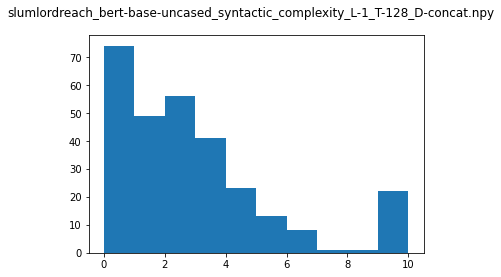


black_bert-base-uncased_syntactic_complexity_L-1_T-10_D-concat.npy


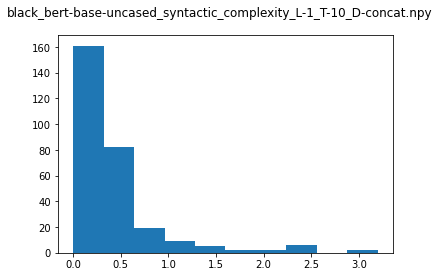


black_bert-base-uncased_syntactic_complexity_L-1_T-128_D-concat.npy


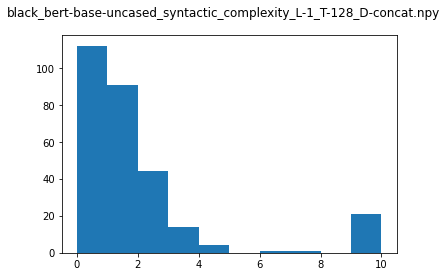


slumlordreach_bert-base-uncased_syntactic_distance_T-10_D-concat.npy


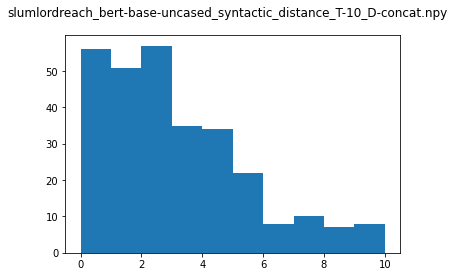


black_bert-base-uncased_syntactic_distance_T-128_D-concat.npy


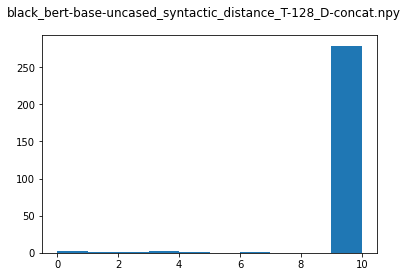


slumlordreach_bert-base-uncased_syntactic_distance_T-128_D-concat.npy


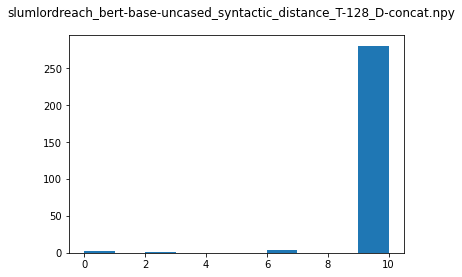


black_bert-base-uncased_syntactic_complexity_L-inf_T-10_D-concat.npy


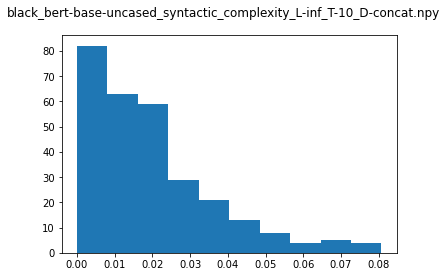


slumlordreach_bert-base-uncased_syntactic_complexity_L-1_T-10_D-concat.npy


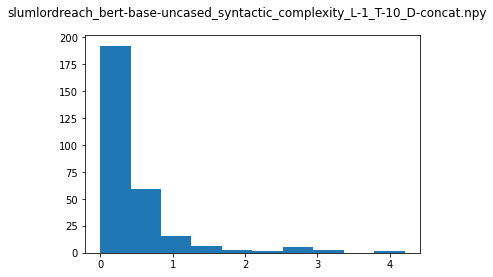


slumlordreach_bert-base-uncased_syntactic_complexity_L-inf_T-10_D-concat.npy


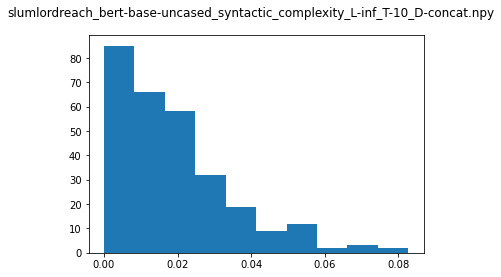


black_bert-base-uncased_syntactic_distance_T-10_D-concat.npy


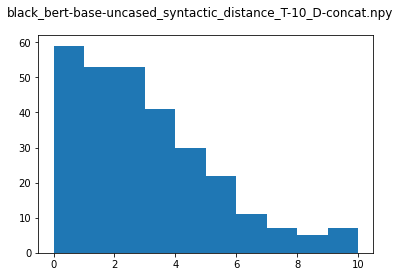

In [19]:
import glob

concat_metrics = [f for f in glob.glob("*.npy") if 'concat' in f and '20' not in f]

basic_stats = []

for concat_file in concat_metrics:
    
    concat = np.load(concat_file, allow_pickle=True)

    non_null = [c for c in concat if c is not None]
    
    magnitudes = [np.linalg.norm(x) for x in non_null]
    variance = np.var(magnitudes)
    basic_stats.append((concat_file, variance))
    
    stacked = np.stack(non_null)
    per_head_var = np.var(stacked, axis=0)
    
    print("\n"+concat_file + "\n=======")   
    plt.hist(per_head_var.clip(0, 10))
    
#     plt.plot(magnitudes)
    plt.suptitle(concat_file)
    plt.show()

## Semantic Composition analysis

black_bert-base-uncased_semantic_composition_0-TRs.npy:
	(534, 1) numpy array.
	534 non-null entries, each of length 26.
	Variance of stimulus: 4.635718113608257.


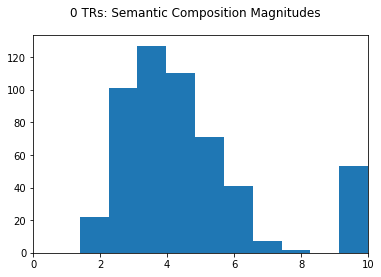

black_bert-base-uncased_semantic_composition_1-TRs.npy:
	(534, 1) numpy array.
	534 non-null entries, each of length 26.
	Variance of stimulus: 3.8284995812554077.


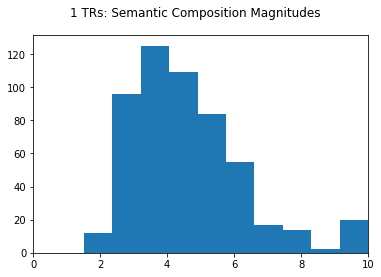

black_bert-base-uncased_semantic_composition_2-TRs.npy:
	(534, 1) numpy array.
	534 non-null entries, each of length 26.
	Variance of stimulus: 3.395289368807639.


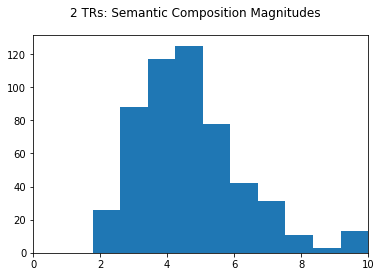

black_bert-base-uncased_semantic_composition_3-TRs.npy:
	(534, 1) numpy array.
	534 non-null entries, each of length 26.
	Variance of stimulus: 3.046315859172982.


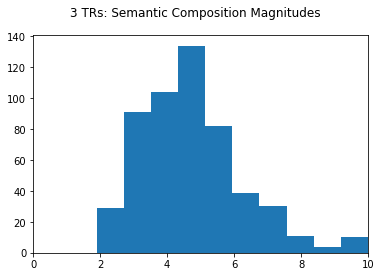

black_bert-base-uncased_semantic_composition_4-TRs.npy:
	(534, 1) numpy array.
	534 non-null entries, each of length 26.
	Variance of stimulus: 2.700756508433889.


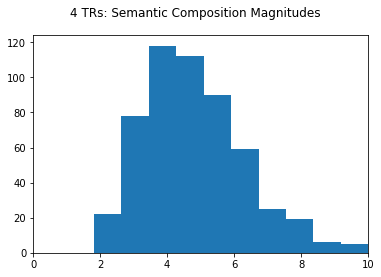

black_bert-base-uncased_semantic_composition_5-TRs.npy:
	(534, 1) numpy array.
	534 non-null entries, each of length 26.
	Variance of stimulus: 2.2156486564599236.


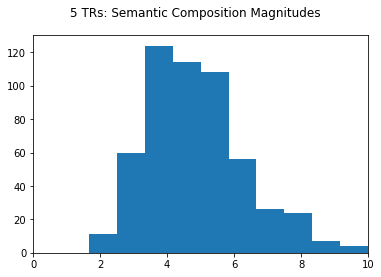

black_bert-base-uncased_semantic_composition_10-TRs.npy:
	(534, 1) numpy array.
	534 non-null entries, each of length 26.
	Variance of stimulus: 2.0498418203176847.


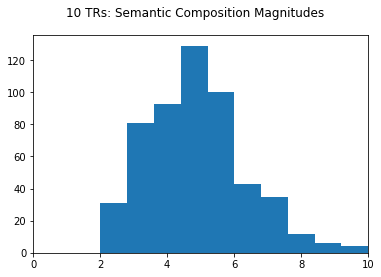

black_bert-base-uncased_semantic_composition_20-TRs.npy:
	(534, 1) numpy array.
	534 non-null entries, each of length 26.
	Variance of stimulus: 1.9677892196408229.


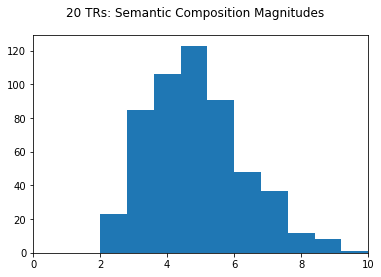

black_bert-base-uncased_semantic_composition_120-TRs.npy:
	(534, 1) numpy array.
	534 non-null entries, each of length 26.
	Variance of stimulus: 2.1634533860199383.


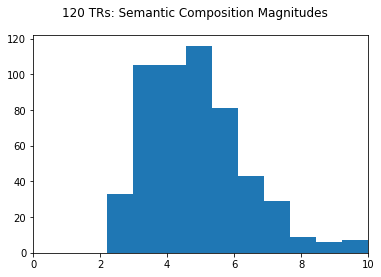

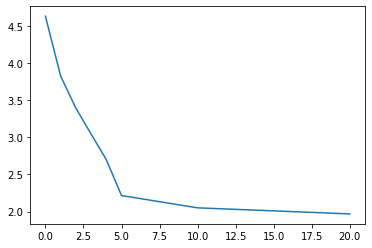

In [83]:
base_string = "{}_{}_semantic_composition_{}-TRs.npy"
composition_window_trs = [0, 1, 2, 3, 4, 5, 10, 20, 120]

basic_stats = []

for window in composition_window_trs:
    
    composition_file = base_string.format(STIMULUS, MODEL, window)
    
    composition = np.load(composition_file, allow_pickle=True)
    print("{}:\n\t{} numpy array.".format(composition_file, composition.shape))
    
    list_of_lists = [c[0] for c in composition if c is not None]
    print("\t{} non-null entries, each of length {}.".format(len(list_of_lists), len(list_of_lists[0])))
        
    magnitudes = [np.linalg.norm(x) for x in list_of_lists]
    variance = np.var(magnitudes)
    print("\tVariance of stimulus: {}.".format(variance))

    basic_stats.append((window, variance, magnitudes))
    plt.hist(np.clip(magnitudes, a_min=0, a_max=10))
    plt.xlim(0,10)
    plt.suptitle("{} TRs: Semantic Composition Magnitudes\n".format(window))
    plt.show()
    
plt.plot([s[0] for s in basic_stats[:-1]], [s[1] for s in basic_stats[:-1]])
# for s in basic_stats:
#     print("{} TRs: variance {}".format(s[0], s[1]))

In [87]:
basic_stats[0]

for s in basic_stats:
    foo.stimulus_df["semantic_{}".format(s[0])] = s[2]

In [92]:
# All of the 10-magnitude semantic-0 windows are empty TRs
foo.stimulus_df.sort_values("semantic_0", ascending=False).head(10)

,tr,start_ts,end_ts,tr.1,phoneme_vector,n_phonemes,tokens,n_tokens,tr_shift,prev_tr,semantic_0,semantic_1,semantic_2,semantic_3,semantic_4,semantic_5,semantic_10,semantic_20,semantic_120
267,267,NaN,NaN,267,NaN,NaN,,0.0,NaN,NaN,10.12098,5.213956,5.473096,6.084009,5.190739,4.730173,4.988689,5.487190,4.454245
104,104,NaN,NaN,104,NaN,NaN,,0.0,NaN,NaN,10.12098,12.125739,4.694726,5.550145,5.242416,5.896296,5.381197,4.976490,5.274033
210,210,NaN,NaN,210,NaN,NaN,,0.0,NaN,NaN,10.12098,5.159545,4.753373,6.495642,6.687881,6.985307,5.887009,6.069081,7.913998
216,216,NaN,NaN,216,NaN,NaN,,0.0,NaN,NaN,10.12098,4.289599,4.268441,4.224968,4.476367,4.363392,4.066923,4.083075,5.868897
222,222,NaN,NaN,222,NaN,NaN,,0.0,NaN,NaN,10.12098,6.392119,6.122932,7.138283,6.700949,7.107169,6.929265,7.076125,6.705675
223,223,NaN,NaN,223,NaN,NaN,,0.0,NaN,NaN,10.12098,12.125739,6.820613,6.377802,7.479111,7.026903,6.984780,7.076125,6.575625
243,243,NaN,NaN,243,NaN,NaN,,0.0,NaN,NaN,10.12098,3.655644,4.741260,4.639576,4.809344,4.823622,5.060467,5.217996,4.374267
437,437,NaN,NaN,437,NaN,NaN,,0.0,NaN,NaN,10.12098,4.042264,3.358754,3.646273,4.755948,3.927987,4.919002,4.583480,4.796582
265,265,NaN,NaN,265,NaN,NaN,,0.0,NaN,NaN,10.12098,6.664588,6.720226,5.907961,6.054752,5.978247,5.668523,6.530249,5.453461
268,268,NaN,NaN,268,NaN,NaN,,0.0,NaN,NaN,10.12098,12.125739,5.473096,5.679229,6.300876,5.235856,5.361681,5.147768,4.661828


In [95]:
# All of the 12-magnitude semantic-0 windows are empty TRs
foo.stimulus_df.sort_values("semantic_4", ascending=False).head(10)[["tr", "tokens", "semantic_0", "semantic_1", "semantic_2", "semantic_4", "semantic_5"]]

,tr,tokens,semantic_0,semantic_1,semantic_2,semantic_4,semantic_5
288,288,,10.120980,12.125739,13.413522,15.059643,6.431725
108,108,,10.120980,12.125739,13.413522,15.059643,9.004570
107,107,,10.120980,12.125739,13.413522,15.059643,5.787079
197,197,And,4.139816,8.301531,10.230412,10.536220,11.502589
13,13,and,4.139816,5.632765,9.306528,10.483329,10.715409
140,140,as it turns out he,7.123513,7.826175,8.768817,9.150739,9.212953
299,299,recipes,5.397846,9.767514,9.870115,9.124095,8.804240
46,46,Missouri,7.400371,6.293546,7.659658,8.939651,9.050249
110,110,mind,4.934963,7.972274,8.236488,8.620571,8.769292
70,70,album,5.886784,7.823436,7.692533,8.461176,9.134628


black_bert-base-uncased_semantic_composition_0-TRs.npy:
	(534, 1) numpy array.
	534 non-null entries, each of length 26.
[0.99812734 0.99812734 0.99812734 0.99812734 0.99812734 0.99812734
 0.99812734 0.99812734 0.99812734 0.99812734 0.99812734 0.99812734
 0.99812734 0.99812734 0.99812734 0.99812734 0.99812734 0.99812734
 0.99812734 0.99812734 0.99812734 0.99812734 0.99812734 0.99812734
 0.99812734 0.99812734]
black_bert-base-uncased_semantic_composition_1-TRs.npy:
	(534, 1) numpy array.
	534 non-null entries, each of length 26.
[0.99812734 0.99812734 0.99812734 0.99812734 0.99812734 0.99812734
 0.99812734 0.99812734 0.99812734 0.99812734 0.99812734 0.99812734
 0.99812734 0.99812734 0.99812734 0.99812734 0.99812734 0.99812734
 0.99812734 0.99812734 0.99812734 0.99812734 0.99812734 0.99812734
 0.99812734 0.99812734]


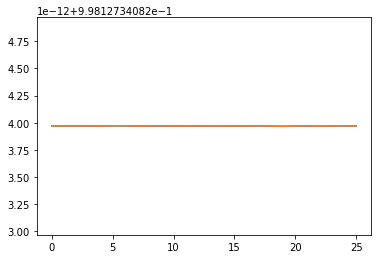

In [81]:
base_string = "{}_{}_semantic_composition_{}-TRs.npy"
composition_window_trs = [0, 1,]# 2, 3, 4, 5, 10, 20, 120]

basic_stats = []

for window in composition_window_trs:
    
    composition_file = base_string.format(STIMULUS, MODEL, window)
    
    composition = np.load(composition_file, allow_pickle=True)
    print("{}:\n\t{} numpy array.".format(composition_file, composition.shape))
    
    list_of_lists = [c[0] for c in composition if c is not None]
    print("\t{} non-null entries, each of length {}.".format(len(list_of_lists), len(list_of_lists[0])))
    
    # Concat into an actual NP array
    arr = np.array(list_of_lists)
    # Get variance for each location in array (so this will be a 26-width vector measuring variance)
    variance = np.var(arr, axis=0)

    print(variance)
    plt.plot(variance)
#     magnitudes = [np.linalg.norm(x) for x in list_of_lists]
#     print("\tVariance of stimulus: {}.".format(variance))

#     basic_stats.append((window, variance))
#     plt.hist(np.clip(magnitudes, a_min=0, a_max=10))
#     plt.xlim(0,10)
#     plt.suptitle("{} TRs: Semantic Composition Magnitudes\n".format(window))
#     plt.show()
    
    
# plt.plot([s[0] for s in basic_stats[:-1]], [s[1] for s in basic_stats[:-1]])
# for s in basic_stats:
#     print("{} TRs: variance {}".format(s[0], s[1]))